In [1]:
%load_ext autoreload
%autoreload 2

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [3]:
# This cell must be run only once
current_path = os.getcwd()
print(current_path)
base_path, _ = os.path.split(current_path)
os.chdir(base_path)
os.getcwd()

/Users/francesco/REPOS/qrs-wrapper-library/notebooks


In [55]:
df = pd.read_csv(os.path.join(base_path, "data", "ecg_at_1kHz.csv"))
print(df.shape)
x = df.index.values
df.describe()

(1058138, 2)


ecg     is_r_peak
count  1.058138e+06  1.058138e+06
mean  -1.942709e+01  1.014990e-03
std    1.927397e+03  3.184276e-02
min   -2.615100e+04  0.000000e+00
25%   -9.330000e+02  0.000000e+00
50%   -6.660000e+02  0.000000e+00
75%    4.530000e+02  0.000000e+00
max    1.696300e+04  1.000000e+00

In [56]:
print(df["is_r_peak"].value_counts())

0    1057064
1       1074
Name: is_r_peak, dtype: int64


In [57]:
df.plot(y="ecg", use_index=True)

<Axes: >

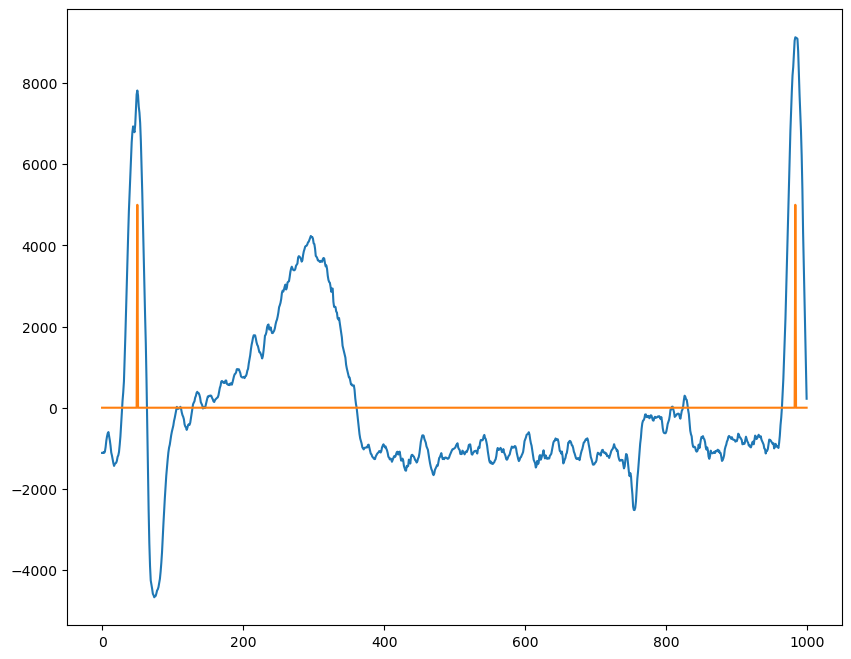

In [58]:
# Segment
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(x[:1000], df["ecg"][:1000])
ax.plot(x[:1000], df["is_r_peak"][:1000]*5000)
plt.show()

## Biosppy

In [59]:
from biosppy.signals import ecg

In [96]:
freq = 1000
data_array = df["ecg"].values
labels_index = df.index[df["is_r_peak"] == 1]
print(len(labels_index))
print(labels_index[:10])

1074
Int64Index([50, 983, 1859, 2736, 3616, 4553, 5526, 6541, 7547, 8523], dtype='int64')


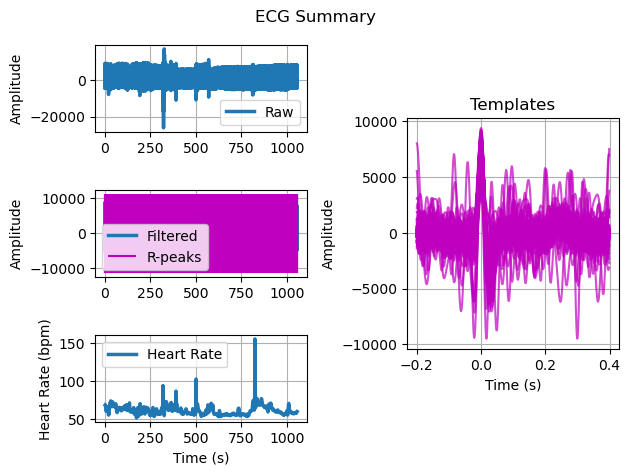

In [61]:
out = ecg.ecg(signal=data_array, sampling_rate=freq, interactive=False)

In [135]:
rpeaks_index = ecg.ASI_segmenter(signal=data_array, sampling_rate=freq)
print(len(rpeaks_index[0]))
print(rpeaks_index.keys())


1122
['rpeaks']


In [87]:
print(df["is_r_peak"].value_counts())
pred = df.index.isin(rpeaks_index[0])
pred_df = pd.DataFrame(index=x)
pred_df["predictions"] = pred.astype(int)
print(len(pred_df["predictions"]))
print(len(df["is_r_peak"]))
mae = mean_absolute_error(df["is_r_peak"], pred_df["predictions"])
mse = mean_squared_error(df["is_r_peak"], pred_df["predictions"])
mape = mean_absolute_percentage_error(df["is_r_peak"], pred_df["predictions"])
print(f"{mae=}")
print(f"{mse=}")
print(f"{mape=}")

0    1057064
1       1074
Name: is_r_peak, dtype: int64
1058138
1058138
mae=0.0015045296549221368
mse=0.0015045296549221368
mape=3490047323169.3853


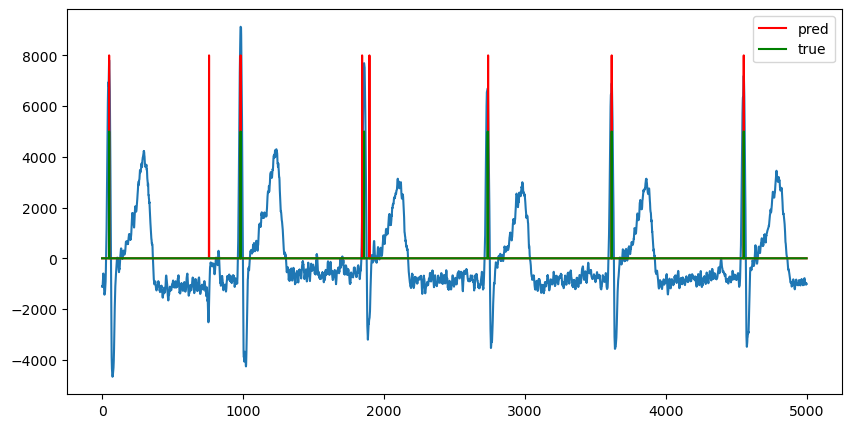

In [120]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x[:5000], df["ecg"][:5000])
ax.plot(x[:5000], pred_df["predictions"][:5000]*8000, color="red", label="pred")
ax.plot(x[:5000], df["is_r_peak"][:5000]*5000, color="green", label="true")
ax.legend()
plt.show()

In [116]:

print(len(labels_index))
print(len(rpeaks_index[0][:len(labels_index)]))
perf = ecg.compare_segmentation(reference=labels_index, test=rpeaks_index[0][:len(labels_index)], sampling_rate=freq)
print(perf.keys())
print(f"{perf['TP']=}")
print(f"{perf['FP']=}")
print(f"{perf['performance']=}")
print(f"{perf['acc']=}")
print(f"{perf['err']=}")
print(len(perf["match"]))

1074
1074
['TP', 'FP', 'performance', 'acc', 'err', 'match', 'deviation', 'mean_deviation', 'std_deviation', 'mean_ref_ibi', 'std_ref_ibi', 'mean_test_ibi', 'std_test_ibi']
perf['TP']=1012
perf['FP']=0
perf['performance']=0.9422718808193669
perf['acc']=1.0
perf['err']=0.0
1012


In [133]:
# The compare_segmentation doesn't seem to work...
# Let's see by ourselves with zero tolerance
matched = np.intersect1d(labels_index, rpeaks_index[0], assume_unique=True)
print(f"{len(matched)=}")
missed = np.setdiff1d(labels_index, rpeaks_index[0])
print(f"{len(missed)=}")


len(matched)=302
len(missed)=772
